In [1]:
# %load_ext memory_profiler

# Capstone V7 model

Fork: V6

same as capstoneV6 but with class weight.

The validation F1-score is {} at a threshold of {}.

# Constants

In [2]:
MODEL_VERSION = 'capstoneV7'
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
MAX_WORDS = 50000

## Common english contraction mappings (wikipedia):
https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

In [3]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [4]:
PUNCT = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [5]:
SPECIAL_PUNCT = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}

In [6]:
PUNCT_MAPPING = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [7]:
MISPELL_MAPPING = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

# Helpers

## Embedding helpers

In [8]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import os

def loadEmbeddings(path, dimensions, mode='r', encoding=None, errors=None):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    f = open(path, buffering=((2<<16) + 8), mode=mode, encoding=encoding, errors=errors)
    for line in f:
        if len(line) <= 100:
            continue
        values = line.split()
        word = ''.join(values[:-dimensions])
        coefs = np.asarray(values[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [9]:
def loadEmbeddingsGensim(path, dimensions, binary=True):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    gensim_vecs = KeyedVectors.load_word2vec_format(path, binary=binary)
    for word, vector in zip(gensim_vecs.vocab, gensim_vecs.vectors):
        coefs = np.asarray(vector[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [10]:
def getEmbeddingMatrix(embedding, word_index):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    nb_words = min(MAX_WORDS, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

### Helper to replace contractions in dataset

In [11]:
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([CONTRACTION_MAPPING[t] if t in CONTRACTION_MAPPING else t for t in text.split(" ")])
    return text

### Helper to remap punctuations in dataset

In [12]:
def clean_special_chars(text):
    for p in PUNCT_MAPPING:
        text = text.replace(p, PUNCT_MAPPING[p])
    
    for p in PUNCT:
        text = text.replace(p, ' ' + p + ' ')
    
    for s in SPECIAL_PUNCT:
        text = text.replace(s, SPECIAL_PUNCT[s])
    
    return text

### Helper to correct common mispellings

In [13]:
def correct_spelling(x):
    for word in MISPELL_MAPPING.keys():
        x = x.replace(word, MISPELL_MAPPING[word])
    return x

## Coverage helpers

In [14]:
from collections import Counter

def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = Counter()
    for sentence in sentences:
        for word in sentence:
            vocab[word] += 1
    return vocab

In [15]:
import operator

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

# Import test/train dataset

In [16]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1

# Analyze train and test data

In [17]:
print("Sample insincere questions")
train_df.loc[train_df['target'] == 1].sample(10)

Sample insincere questions


,qid,question_text,target
394312,4d411f5c1dcb2896db87,What make British girls look older than their age? And hardly to find they smile on their profile picture?,1
1222217,ef8b1a43b47e9a3eb76b,Is it fair to conclude that Japanese are the most cunning people on Earth followed by the Chinese?,1
214771,2a015c08e038519536f2,Has anyone ever had a sex chat on Quora?,1
764005,95aea62c252aeac234aa,Why do British kids wear ugly uniforms to school? Why can't they be free like us Americans?,1
631670,7bb3e6cb13403558ec3f,Why did the British do so much damage with their crime empire?,1
456994,5985aa8823d27f1b1aad,Why do south Indians not call themselves “Indian”?,1
1277913,fa72edfc198de343e639,When will we Palestinians learn that it's better to coexist with Israelis than to fight them?,1
747320,9264c2cef848243ba028,Are followers of Christianity ordained by the Lord to eat dog skin?,1
739893,90e8509ebcda52b8c5dc,Is it true that Muslim boys in India specifically target school going Hindu girls as they are more vulnerable and easy prey?,1
693093,87c1f99a21bfcc7ecea1,Is Ben Shapiro right about transgenderism being a kind of mental illness?,1


In [18]:
print("Sample sincere questions")
train_df.loc[train_df['target'] == 0].sample(10)

Sample sincere questions


,qid,question_text,target
912636,b2d5a128a066226eaf19,When will the DU JAT 2017 cutff be released?,0
1047476,cd4036ce4933381391b8,Amtrak tantra can u see this I'm possessed LOL this is no a dance?,0
276982,36335bc7b4a1a5b8afe0,Have you ever became depressed and stay indoors for long periods? How did you get out of your depression?,0
789340,9aa7565cb4ee2892b4e4,What are the skills required from an individual to be effective in a team?,0
877512,abecb1ccd1350d130b22,Who is the highest tax payer in India?,0
386493,4bb8b160d9980339bae6,Where can I find the best villa developers in Trivandrum?,0
168829,20fea542428b2bf3cde5,Why does Zivame send 1 million SMSs everyday? Who heads their brand team?,0
983748,c0bd274eeb45aec61bbe,I'm afraid of death. How do I confront my own mortality?,0
135083,1a6ec31e33fc13f68320,Is it harder to get a job because of your racial background?,0
278136,367029d4231f902933ed,Were US flamethrowers effective for destroying Vietcong booby traps in the Vietnam War?,0


In [19]:
import matplotlib.pyplot as plt
import numpy as np

target_ratios = train_df.target.value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios (target)')
plt.show()

0    0.93813
1    0.06187
Name: target, dtype: float64


<Figure size 640x480 with 1 Axes>

In [20]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [21]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [22]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 70.


In [23]:
print('Max character length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x)))))
print('Max character length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x)))))

Max character length of questions in train is 1017.
Max character length of questions in test is 588.


In [24]:
print('p999 character length of questions in train is {0:.0f}.'.format(np.percentile(train_df['question_text'].apply(lambda x: len(x)), 99.9)))
print('p999 character length of questions in test is {0:.0f}.'.format(np.percentile(test_df['question_text'].apply(lambda x: len(x)), 99.9)))

p999 character length of questions in train is 249.
p999 character length of questions in test is 249.


# Data processing


## TODO: Feature engineering

Add feature engineering here.

In [25]:
%%time

train_df['treated_question'] = train_df['question_text'].apply(lambda x: x.lower())
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_contractions(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_special_chars(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: correct_spelling(x))

test_df['treated_question'] = test_df['question_text'].apply(lambda x: x.lower())
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_contractions(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_special_chars(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: correct_spelling(x))

CPU times: user 53.3 s, sys: 388 ms, total: 53.7 s
Wall time: 53.7 s
Parser   : 100 ms


## Fill data

In [26]:
X_train = train_df['treated_question'].fillna('+++').tolist()
y_train = train_df['target']
X_test = test_df['treated_question'].fillna('+++').tolist()


print('Found %s training questions.' % len(X_train))
print('Found %s test questions.' % len(X_test))

Found 1306122 training questions.
Found 56370 test questions.


In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, split=' ', filters='',
                       char_level=False, oov_token=None, document_count=0,
                      )
                                   
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Shape of X_train: (1306122, 100)
Shape of y_train: (1306122,)
Found 195975 unique tokens.


## Save tokenized data + word index

In [28]:
%%time

import gc
import pickle

test_df.to_pickle('test_df.pkl')

np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
y_train.to_pickle('y_train.pkl')

pickle.dump(word_index, open('word_index.pkl', 'wb'))

del X_train
del X_test
del y_train

gc.collect()


CPU times: user 316 ms, sys: 448 ms, total: 764 ms
Wall time: 759 ms


## Build vocabulary with counts

In [29]:
%%time

train_vocab = build_vocab(train_df['treated_question'])
del train_df
test_vocab = build_vocab(test_df['treated_question'])
del test_df

vocab = train_vocab + test_vocab
del train_vocab
del test_vocab

CPU times: user 14.6 s, sys: 544 ms, total: 15.1 s
Wall time: 15.1 s


## Load embeddings, measure coverage and save embedding matrix

# Restore point (optional)

In [30]:
'''
%%time

import pickle

word_index = pickle.load(open('word_index.pkl', 'rb'))
'''

"\n%%time\n\nimport pickle\n\nword_index = pickle.load(open('word_index.pkl', 'rb'))\n"

In [31]:
%%time

import gc

print('glove:')
glove_path = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
embeddings_index = loadEmbeddings(glove_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('glove.npy', embedding_matrix)

glove:
Loading embeddings from: ../input/embeddings/glove.840B.300d/glove.840B.300d.txt
Found 2195892 word vectors.
Found embeddings for 63.10% of vocab
Found embeddings for  99.39% of all text
CPU times: user 2min 47s, sys: 7.16 s, total: 2min 54s
Wall time: 2min 54s


In [32]:
print('paragram:')
paragram_path = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
embeddings_index = loadEmbeddings(paragram_path, EMBEDDING_DIM, encoding='utf8', errors='ignore')
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('paragram.npy', embedding_matrix)

paragram:
Loading embeddings from: ../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt
Found 1703663 word vectors.
Found embeddings for 74.06% of vocab
Found embeddings for  99.64% of all text


In [33]:
print('wiki:')
wiki_path = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
embeddings_index = loadEmbeddings(wiki_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('wiki.npy', embedding_matrix)

wiki:
Loading embeddings from: ../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec
Found 999994 word vectors.
Found embeddings for 48.05% of vocab
Found embeddings for  98.81% of all text


In [34]:
print('google_news:')
google_news_path = '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
embeddings_index = loadEmbeddingsGensim(google_news_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('google_news.npy', embedding_matrix)

google_news:
Loading embeddings from: ../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin
Found 3000000 word vectors.
Found embeddings for 38.68% of vocab
Found embeddings for  78.84% of all text


In [35]:
del word_index
del vocab
gc.collect()

0

# Oversample training data

In [36]:
'''
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
'''


'\nfrom imblearn.over_sampling import SMOTE\n\nsm = SMOTE(random_state=42, ratio = 1.0)\nX_train, y_train = sm.fit_sample(X_train, y_train)\n'

In [37]:
'''
balanced_train_df = pd.DataFrame()
balanced_train_df[0] = np.array(y_train)

target_ratios = balanced_train_df[0].value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios after SMOTE (target)')
'''

"\nbalanced_train_df = pd.DataFrame()\nbalanced_train_df[0] = np.array(y_train)\n\ntarget_ratios = balanced_train_df[0].value_counts(normalize=True)\n\nprint(target_ratios)\n\ntarget_ratios.plot(kind='bar', title='Ratios after SMOTE (target)')\n"

# Setup model

# Restore point

In [38]:
%%time

import numpy as np
import pandas as pd
import pickle

test_df = pd.read_pickle('test_df.pkl')

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = pd.read_pickle('y_train.pkl')


CPU times: user 64 ms, sys: 224 ms, total: 288 ms
Wall time: 2.18 s


## Embeddings Layers

In [39]:
from keras.layers import Embedding

embedding_layers = {}

embedding_matrix = np.load('glove.npy')
embedding_layers['glove'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

embedding_matrix = np.load('paragram.npy')
embedding_layers['paragram'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

embedding_matrix = np.load('wiki.npy')
embedding_layers['wiki'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

embedding_matrix = np.load('google_news.npy')
embedding_layers['google_news'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

## NN: Bidirectional GRU per embedding with concactenation

In [40]:
%%time 

from keras.layers import Dense, Dropout, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional
from keras.layers import Activation, BatchNormalization, CuDNNGRU
from keras.layers import SpatialDropout1D, Concatenate, Flatten, Reshape
from keras.regularizers import l2
from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

a = embedding_layers['glove'] (inp)
a = Bidirectional(CuDNNGRU(64, return_sequences=True))(a)
a = BatchNormalization()(a)
a = GlobalMaxPool1D()(a)
a = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(a)
a = BatchNormalization()(a)
a = Activation("relu")(a)
a = Dropout(0.1)(a)

b = embedding_layers['paragram'] (inp)
b = Bidirectional(CuDNNGRU(64, return_sequences=True))(b)
b = BatchNormalization()(b)
b = GlobalMaxPool1D()(b)
b = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(b)
b = BatchNormalization()(b)
b = Activation("relu")(b)
b = Dropout(0.1)(b)

c = embedding_layers['wiki'] (inp)
c = Bidirectional(CuDNNGRU(64, return_sequences=True))(c)
c = BatchNormalization()(c)
c = GlobalMaxPool1D()(c)
c = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Dropout(0.1)(c)

d = embedding_layers['google_news'] (inp)
d = Bidirectional(CuDNNGRU(64, return_sequences=True))(d)
d = BatchNormalization()(d)
d = GlobalMaxPool1D()(d)
d = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(d)
d = BatchNormalization()(d)
d = Activation("relu")(d)
d = Dropout(0.1)(d)

x = Concatenate(axis=1)([a, b, c, d])
x = Dense(32, kernel_regularizer=l2(0.01), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dense(1, use_bias=False)(x)
x = BatchNormalization()(x)
out = Activation("sigmoid")(x)

model = Model(inp, out)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     15000000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     15000000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     15000000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [41]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

# Compile the model

In [42]:


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1, recall, precision])

# serialize model

In [43]:
model.save('model.h5')
print("Saved model to disk")

Saved model to disk


# Setup f1-score, precision and recall metrics

In [44]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint(MODEL_VERSION + '.weights_checkpoint.h5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)

In [45]:
'''
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

class Metrics(Callback):


    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average='binary')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()
'''

'\nfrom keras.callbacks import Callback\nfrom sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support\n\nclass Metrics(Callback):\n\n\n    def on_train_begin(self, logs={}):\n        self.val_f1s = []\n        self.val_recalls = []\n        self.val_precisions = []\n \n\n    def on_epoch_end(self, epoch, logs={}):\n        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()\n        val_targ = self.validation_data[1]\n        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average=\'binary\')\n        self.val_f1s.append(_val_f1)\n        self.val_recalls.append(_val_recall)\n        self.val_precisions.append(_val_precision)\n        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))\n        return\n\nmetrics = Metrics()\n'

# Compute Class Weights

Since there is a significant target inbalance.

In [46]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

print (class_weights)

[0.53297527 8.08143794]


## Split train/validation

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8,
                                              random_state=233)

/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Train the model

Use model checkpointing to save the model that attains the best validation loss.

In [48]:
%%time


hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], class_weight=class_weights, epochs=2, batch_size=256)


Train on 1044897 samples, validate on 261225 samples
Epoch 1/2
1044897/1044897 [==============================] - 473s 453us/step - loss: 0.3005 - acc: 0.9437 - f1: 0.6058 - recall: 0.6721 - precision: 0.5919 - val_loss: 0.2600 - val_acc: 0.9153 - val_f1: 0.5598 - val_recall: 0.8906 - val_precision: 0.4133

Epoch 00001: val_f1 improved from -inf to 0.55982, saving model to capstoneV7.weights_checkpoint.h5
Epoch 2/2
1044897/1044897 [==============================] - 462s 442us/step - loss: 0.1116 - acc: 0.9618 - f1: 0.6577 - recall: 0.6121 - precision: 0.7347 - val_loss: 0.1135 - val_acc: 0.9588 - val_f1: 0.6563 - val_recall: 0.6600 - val_precision: 0.6666

Epoch 00002: val_f1 improved from 0.55982 to 0.65627, saving model to capstoneV7.weights_checkpoint.h5
CPU times: user 15min 43s, sys: 2min 36s, total: 18min 20s
Wall time: 15min 43s


# Predict validation labels

In [49]:
%%time

pred_val = model.predict([X_val], batch_size=1024, verbose=1)

261225/261225 [==============================] - 16s 62us/step
CPU times: user 15.5 s, sys: 3.08 s, total: 18.6 s
Wall time: 16.2 s


# Find optimal threshold

In [50]:
from sklearn.metrics import f1_score, precision_score, recall_score

def optimalThreshold(y_true,y_pred):
    idx = 0
    cur_f1 = 0
    cur_prec = 0
    cur_recall = 0
    max_f1 = 0
    thres = 0
    for idx in np.arange(0.1, 0.501, 0.01):
        cur_f1 = f1_score(y_true, np.array(y_pred)> idx)
        cur_recall = recall_score(y_true, np.array(y_pred)> idx)
        cur_prec = precision_score(y_true, np.array(y_pred)> idx)
        print('Current threshold is {:.4f} with F1 score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}'
              .format(idx, cur_f1, cur_recall, cur_prec)
             )
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            thres = idx
    print('optimal threshold is {:.4f} with F1 score: {:.4f}'.format(thres, max_f1))
    return thres
threshold = optimalThreshold(y_val,pred_val)

Current threshold is 0.1000 with F1 score: 0.5182, Recall score: 0.9268, Precision score: 0.3596
Current threshold is 0.1100 with F1 score: 0.5341, Recall score: 0.9203, Precision score: 0.3762
Current threshold is 0.1200 with F1 score: 0.5476, Recall score: 0.9127, Precision score: 0.3912
Current threshold is 0.1300 with F1 score: 0.5598, Recall score: 0.9053, Precision score: 0.4052
Current threshold is 0.1400 with F1 score: 0.5710, Recall score: 0.8985, Precision score: 0.4185
Current threshold is 0.1500 with F1 score: 0.5805, Recall score: 0.8912, Precision score: 0.4304
Current threshold is 0.1600 with F1 score: 0.5893, Recall score: 0.8847, Precision score: 0.4417
Current threshold is 0.1700 with F1 score: 0.5976, Recall score: 0.8786, Precision score: 0.4528
Current threshold is 0.1800 with F1 score: 0.6055, Recall score: 0.8732, Precision score: 0.4634
Current threshold is 0.1900 with F1 score: 0.6122, Recall score: 0.8677, Precision score: 0.4729
Current threshold is 0.2000 wi

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, np.array(pred_val > threshold).astype(int), target_names=['sincere', 'insincere']))


             precision    recall  f1-score   support

    sincere       0.98      0.97      0.98    245044
  insincere       0.61      0.74      0.67     16181

avg / total       0.96      0.96      0.96    261225



[Text(0, 0.5, 'sincere'), Text(0, 1.5, 'insincere')]

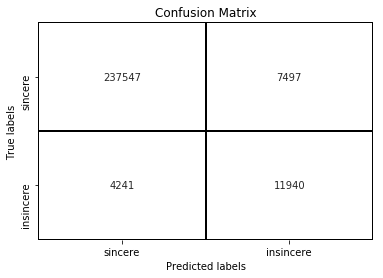

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = confusion_matrix(y_val, np.array(pred_val > threshold).astype(int))
ax = plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', 
                 cmap=ListedColormap(['white']), linecolor='black', 
                 linewidth=1, cbar=False,
                 xticklabels = 1, yticklabels = 1 )


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['sincere', 'insincere'])
ax.yaxis.set_ticklabels(['sincere', 'insincere'])



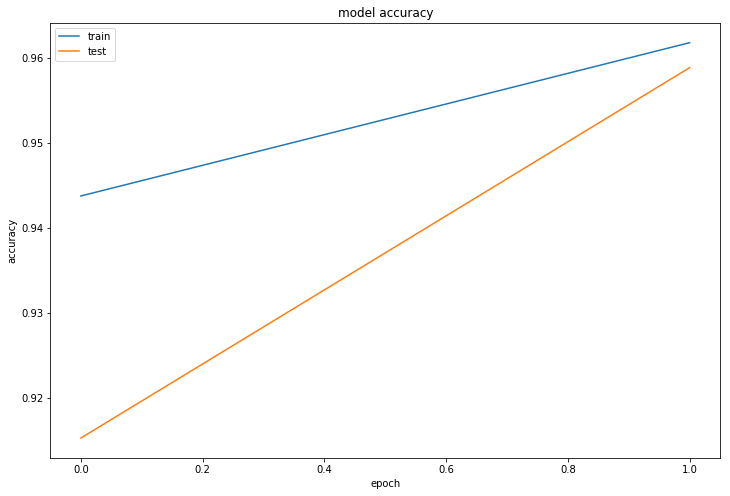

In [54]:
plt.figure(figsize=(12,8))
plt.title('model accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

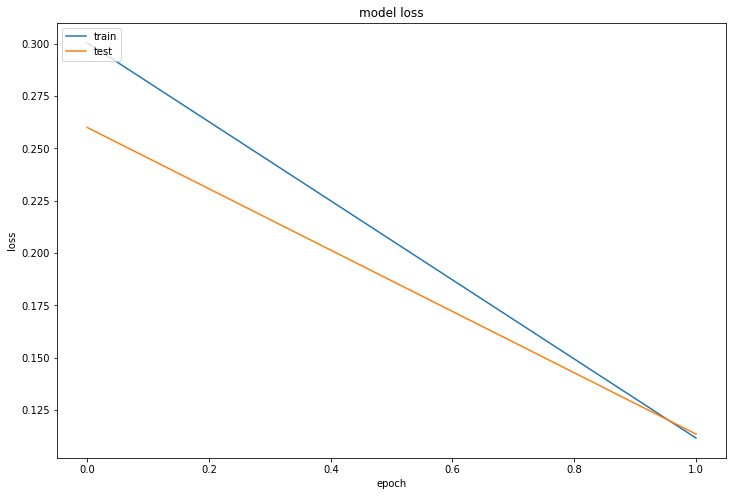

In [55]:
plt.figure(figsize=(12,8))
plt.title('model loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

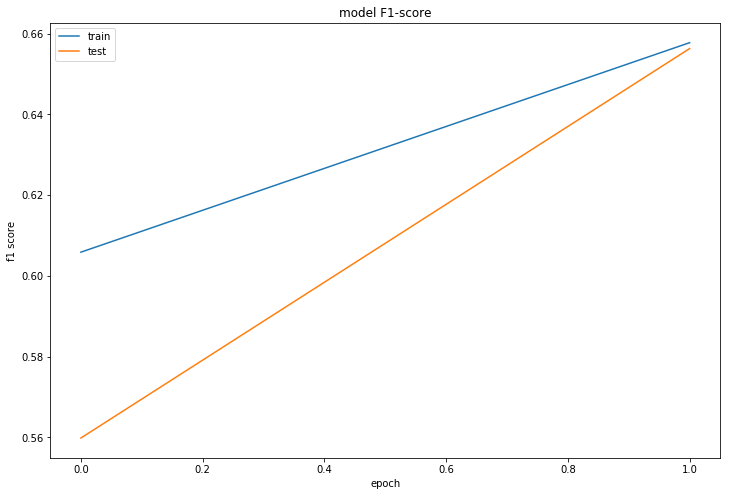

In [56]:
plt.figure(figsize=(12,8))
plt.title('model F1-score')
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize weights

In [57]:
model.save_weights(MODEL_VERSION + '.weights.h5')
print("Saved model weights to disk")

Saved model weights to disk


# Predict test labels

In [58]:
%%time

pred_test = model.predict([X_test], batch_size=1024, verbose=1)

56370/56370 [==============================] - 3s 60us/step
CPU times: user 3.22 s, sys: 692 ms, total: 3.91 s
Wall time: 3.41 s


# Prepare submission

In [59]:
submission_df = pd.DataFrame({"qid":test_df["qid"].values})
submission_df['prediction'] = (pred_test > threshold).astype(int)
submission_df.to_csv("submission.csv", index=False)

In [60]:
type(hist)

keras.callbacks.History

In [61]:
import pickle


pickle_out = open(MODEL_VERSION + '.hist.pkl',"wb")
pickle.dump(hist, pickle_out)
pickle_out.close()